# Exploratory Data Analysis: World Happiness Prediction (2015-2019)

### By Natalia López Gallego

-----------------------------------------------------------------------------



This notebook performs an exploratory data analysis (EDA) and predictive modeling on world happiness datasets from 2015 to 2019. The data comes from the world happiness reports, which include variables such as GDP per capita, social support, life expectancy, freedom, generosity, and perception of corruption.

**Objectives**:
- Explore the distribution, correlations, and trends of the variables.
- Prepare the data to train a regression model that predicts the normalized `happiness_score` in the range [0, 10].
- Evaluate the model's performance using metrics like MSE and R².

**Assumptions**:
- The datasets for different years have similar structures but inconsistent column names that will be standardized.
- Missing values will be handled through imputation or removal depending on their impact.

**Limitations**:
- Differences in columns between years may limit comparability.
- The amount of data per year is limited (~150-158 rows), which may affect the model's generalization.

#### Metadata
- **Author**: Natalia López Gallego
- **Python Version**: 3.12.10

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy.stats as stats
from scipy.stats import normaltest, skew, kurtosis

## 1. Data Loading and Cleaning

In this section, we load the datasets from 2015 to 2019, standardize the column names, convert them to `snake_case` format, and select only the common columns to facilitate analysis and modeling.

In [2]:
data = [
    "../data/external/2015.csv",
    "../data/external/2016.csv",
    "../data/external/2017.csv",
    "../data/external/2018.csv",
    "../data/external/2019.csv"
]

dfs = {}  # Dictionary to save DataFrames by year

for file in data:
    # Extract year from filename correctly
    year = file.split("/")[-1][:4]  # "2015.csv" → "2015"
    df = pd.read_csv(file)
    dfs[year] = df  # Save the DataFrame with key = year

In [3]:
for year, df in dfs.items():
    print(f"\n{year} DataFrame:\n")
    df.info()


2015 DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Country                        158 non-null    object 
 1   Region                         158 non-null    object 
 2   Happiness Rank                 158 non-null    int64  
 3   Happiness Score                158 non-null    float64
 4   Standard Error                 158 non-null    float64
 5   Economy (GDP per Capita)       158 non-null    float64
 6   Family                         158 non-null    float64
 7   Health (Life Expectancy)       158 non-null    float64
 8   Freedom                        158 non-null    float64
 9   Trust (Government Corruption)  158 non-null    float64
 10  Generosity                     158 non-null    float64
 11  Dystopia Residual              158 non-null    float64
dtypes: float64(9), int64(1), object(

In [4]:
# Diccionario de nombres estándar por año
column_renames = {
    "2015": {
        "Country": "Country",
        "Region": "Region",
        "Happiness Rank": "Happiness Rank",
        "Happiness Score": "Happiness Score",
        "Standard Error": "Standard Error",
        "Economy (GDP per Capita)": "Economy",
        "Family": "Family",
        "Health (Life Expectancy)": "Health",
        "Freedom": "Freedom",
        "Trust (Government Corruption)": "Trust",
        "Generosity": "Generosity",
        "Dystopia Residual": "Dystopia Residual"
    },
    "2016": {
        "Country": "Country",
        "Region": "Region",
        "Happiness Rank": "Happiness Rank",
        "Happiness Score": "Happiness Score",
        "Lower Confidence Interval": "CI Lower",
        "Upper Confidence Interval": "CI Upper",
        "Economy (GDP per Capita)": "Economy",
        "Family": "Family",
        "Health (Life Expectancy)": "Health",
        "Freedom": "Freedom",
        "Trust (Government Corruption)": "Trust",
        "Generosity": "Generosity",
        "Dystopia Residual": "Dystopia Residual"
    },
    "2017": {
        "Country": "Country",
        "Happiness.Rank": "Happiness Rank",
        "Happiness.Score": "Happiness Score",
        "Whisker.high": "CI Upper",
        "Whisker.low": "CI Lower",
        "Economy..GDP.per.Capita.": "Economy",
        "Family": "Family",
        "Health..Life.Expectancy.": "Health",
        "Freedom": "Freedom",
        "Trust..Government.Corruption.": "Trust",
        "Generosity": "Generosity",
        "Dystopia.Residual": "Dystopia Residual"
    },
    "2018": {
        "Overall rank": "Happiness Rank",
        "Country or region": "Country",
        "Score": "Happiness Score",
        "GDP per capita": "Economy",
        "Social support": "Family",
        "Healthy life expectancy": "Health",
        "Freedom to make life choices": "Freedom",
        "Generosity": "Generosity",
        "Perceptions of corruption": "Trust"
    },
    "2019": {
        "Overall rank": "Happiness Rank",
        "Country or region": "Country",
        "Score": "Happiness Score",
        "GDP per capita": "Economy",
        "Social support": "Family",
        "Healthy life expectancy": "Health",
        "Freedom to make life choices": "Freedom",
        "Generosity": "Generosity",
        "Perceptions of corruption": "Trust"
    }
}

# Aplicar renombramiento a cada DataFrame en dfs
for year, df in dfs.items():
    if year in column_renames:
        dfs[year] = df.rename(columns=column_renames[year])


In [5]:
# Función para convertir a snake_case
def to_snake_case(column_name):
    column_name = column_name.lower()  # Convertir a minúsculas
    column_name = re.sub(r'\s+', '_', column_name)  # Reemplazar espacios por guiones bajos
    column_name = re.sub(r'[^\w\s]', '', column_name)  # Eliminar caracteres no alfanuméricos
    return column_name

# Aplicar renombramiento a cada DataFrame
for year, df in dfs.items():
    # Renombrar todas las columnas del DataFrame a snake_case
    df.columns = [to_snake_case(col) for col in df.columns]

In [6]:
# Obtener las columnas comunes entre todos los DataFrames
common_columns = set(dfs['2015'].columns)  # Iniciar con las columnas del primer DataFrame

# Iterar por los DataFrames y actualizar las columnas comunes
for year, df in dfs.items():
    common_columns &= set(df.columns)  # Intersección de columnas

# Convertir las columnas comunes a lista
common_columns = list(common_columns)

# Filtrar los DataFrames para que solo contengan las columnas comunes
for year, df in dfs.items():
    dfs[year] = df[common_columns]  # Filtra solo las columnas comunes

# Verificar el resultado
for year, df in dfs.items():
    print(f"DataFrame para {year} con columnas comunes:\n", df.columns)

DataFrame para 2015 con columnas comunes:
 Index(['happiness_score', 'country', 'happiness_rank', 'freedom', 'family',
       'health', 'economy', 'generosity', 'trust'],
      dtype='object')
DataFrame para 2016 con columnas comunes:
 Index(['happiness_score', 'country', 'happiness_rank', 'freedom', 'family',
       'health', 'economy', 'generosity', 'trust'],
      dtype='object')
DataFrame para 2017 con columnas comunes:
 Index(['happiness_score', 'country', 'happiness_rank', 'freedom', 'family',
       'health', 'economy', 'generosity', 'trust'],
      dtype='object')
DataFrame para 2018 con columnas comunes:
 Index(['happiness_score', 'country', 'happiness_rank', 'freedom', 'family',
       'health', 'economy', 'generosity', 'trust'],
      dtype='object')
DataFrame para 2019 con columnas comunes:
 Index(['happiness_score', 'country', 'happiness_rank', 'freedom', 'family',
       'health', 'economy', 'generosity', 'trust'],
      dtype='object')


## 2. Exploratory Data Analysis

We explore the structure of the data, check for missing values, analyze distributions, correlations, outliers, and temporal trends to better understand the variables and their relationship with `happiness_score`.

In [7]:
for year, df in dfs.items():
    print(f"DataFrame para {year} - Cantidad de Filas y columnas:\n", df.shape)

DataFrame para 2015 - Cantidad de Filas y columnas:
 (158, 9)
DataFrame para 2016 - Cantidad de Filas y columnas:
 (157, 9)
DataFrame para 2017 - Cantidad de Filas y columnas:
 (155, 9)
DataFrame para 2018 - Cantidad de Filas y columnas:
 (156, 9)
DataFrame para 2019 - Cantidad de Filas y columnas:
 (156, 9)


In [8]:
for year, df in dfs.items():
    print(f"Describe para {year}:\n", df.describe(), "\n")

Describe para 2015:
        happiness_score  happiness_rank     freedom      family      health  \
count       158.000000      158.000000  158.000000  158.000000  158.000000   
mean          5.375734       79.493671    0.428615    0.991046    0.630259   
std           1.145010       45.754363    0.150693    0.272369    0.247078   
min           2.839000        1.000000    0.000000    0.000000    0.000000   
25%           4.526000       40.250000    0.328330    0.856823    0.439185   
50%           5.232500       79.500000    0.435515    1.029510    0.696705   
75%           6.243750      118.750000    0.549092    1.214405    0.811013   
max           7.587000      158.000000    0.669730    1.402230    1.025250   

          economy  generosity       trust  
count  158.000000  158.000000  158.000000  
mean     0.846137    0.237296    0.143422  
std      0.403121    0.126685    0.120034  
min      0.000000    0.000000    0.000000  
25%      0.545808    0.150553    0.061675  
50%      0.9

In [40]:
# Función para detectar outliers usando IQR
def detect_outliers(df):
    outliers = {}
    for column in df.select_dtypes(include=[np.number]).columns:
        # Calcular los cuartiles
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Definir los límites para outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Detectar outliers
        outliers[column] = df[(df[column] < lower_bound) | (df[column] > upper_bound)].index.tolist()

    return outliers

# Iterar sobre los DataFrames para detectar outliers
for year, df in dfs.items():
    outliers = detect_outliers(df)
    print(f"Outliers detectados para {year}:\n", outliers, "\n")


Outliers detectados para 2015:
 {'happiness_score': [], 'happiness_rank': [], 'freedom': [], 'family': [147, 152, 157], 'health': [], 'economy': [], 'generosity': [33, 128], 'trust': [0, 2, 3, 5, 7, 8, 16, 19, 23, 27, 71, 90, 129, 153]} 

Outliers detectados para 2016:
 {'happiness_score': [], 'happiness_rank': [], 'freedom': [], 'family': [154], 'health': [], 'economy': [], 'generosity': [29, 32, 78, 118], 'trust': [0, 1, 3, 4, 7, 9, 19, 21, 27, 35, 96, 151]} 

Outliers detectados para 2017:
 {'happiness_score': [], 'happiness_rank': [], 'freedom': [], 'family': [142, 149, 151, 154], 'health': [], 'economy': [], 'generosity': [80, 113], 'trust': [0, 1, 3, 4, 7, 8, 9, 14, 17, 20, 25, 34, 150]} 

Outliers detectados para 2018:
 {'happiness_score': [], 'happiness_rank': [], 'freedom': [136, 141], 'family': [135, 149, 154], 'health': [], 'economy': [19], 'generosity': [95, 129], 'trust': [0, 1, 2, 4, 5, 6, 7, 8, 9, 13, 14, 16, 18, 33, 75, 97, 150]} 

Outliers detectados para 2019:
 {'happ

C:\Users\ntlg2\AppData\Local\Temp\ipykernel_22664\110321826.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)  # Improve readability
C:\Users\ntlg2\AppData\Local\Temp\ipykernel_22664\110321826.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)  # Improve readability
C:\Users\ntlg2\AppData\Local\Temp\ipykernel_22664\110321826.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)  # Improve readability
C:\Users\ntlg2\AppData\Local\Temp\ipykernel_22664\110321826.py:11: UserWarning: set_ticklabels() should

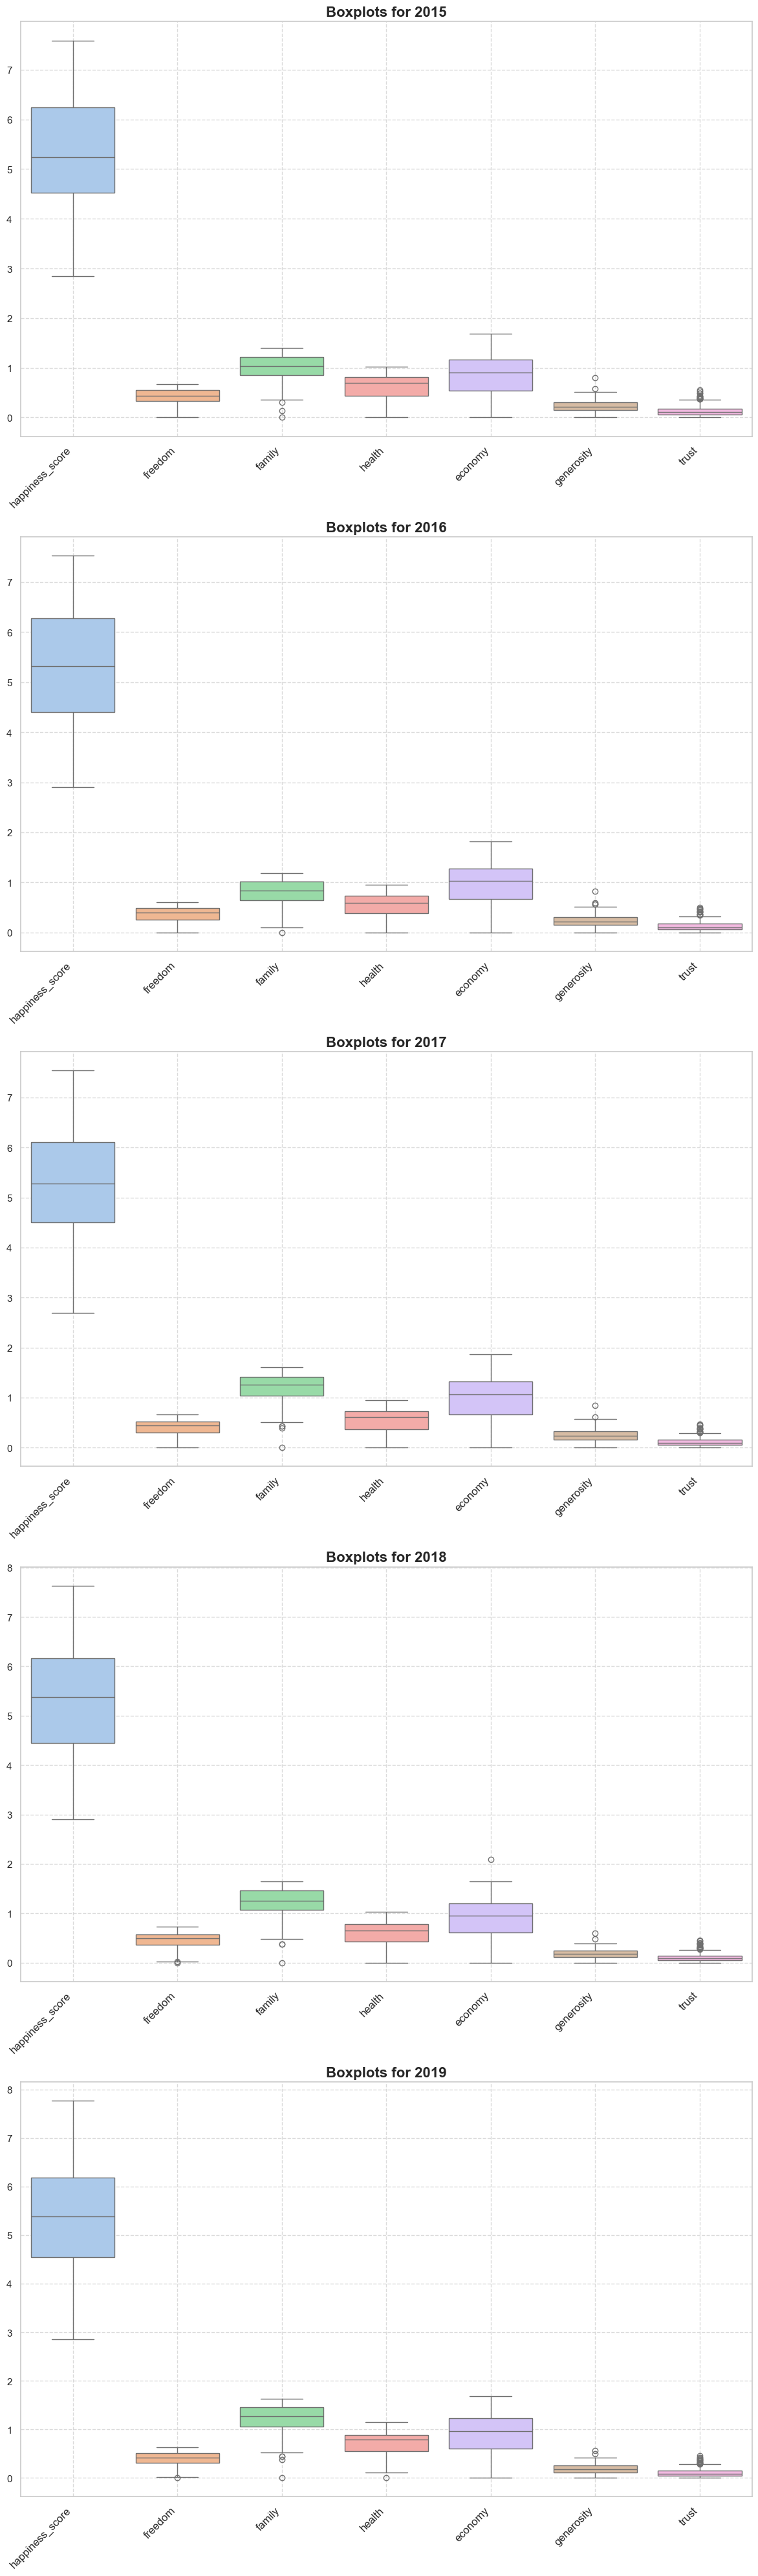

In [39]:
# Define function to plot enlarged boxplots without 'happiness_rank'
def plot_boxplots(dfs):
    fig, axes = plt.subplots(nrows=len(dfs), ncols=1, figsize=(12, 8 * len(dfs)))  # Enlarged figure size

    for i, (year, df) in enumerate(dfs.items()):
        ax = axes[i] if len(dfs) > 1 else axes
        numeric_cols = df.select_dtypes(include=[float, int]).drop(columns=["happiness_rank"], errors="ignore")  # Exclude happiness_rank
        
        sns.boxplot(data=numeric_cols, ax=ax, palette="pastel")
        ax.set_title(f"Boxplots for {year}", fontsize=16, fontweight="bold")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)  # Improve readability
        ax.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# Call the function
plot_boxplots(dfs)

In [10]:
# Iterar sobre los DataFrames y detectar valores nulos
for year, df in dfs.items():
    print(f"Valores nulos para {year}:\n")

    # Mostrar los valores nulos por columna
    null_counts = df.isnull().sum()

    # Imprimir solo las columnas con valores nulos
    print(null_counts[null_counts > 0], "\n")

Valores nulos para 2015:

Series([], dtype: int64) 

Valores nulos para 2016:

Series([], dtype: int64) 

Valores nulos para 2017:

Series([], dtype: int64) 

Valores nulos para 2018:

trust    1
dtype: int64 

Valores nulos para 2019:

Series([], dtype: int64) 



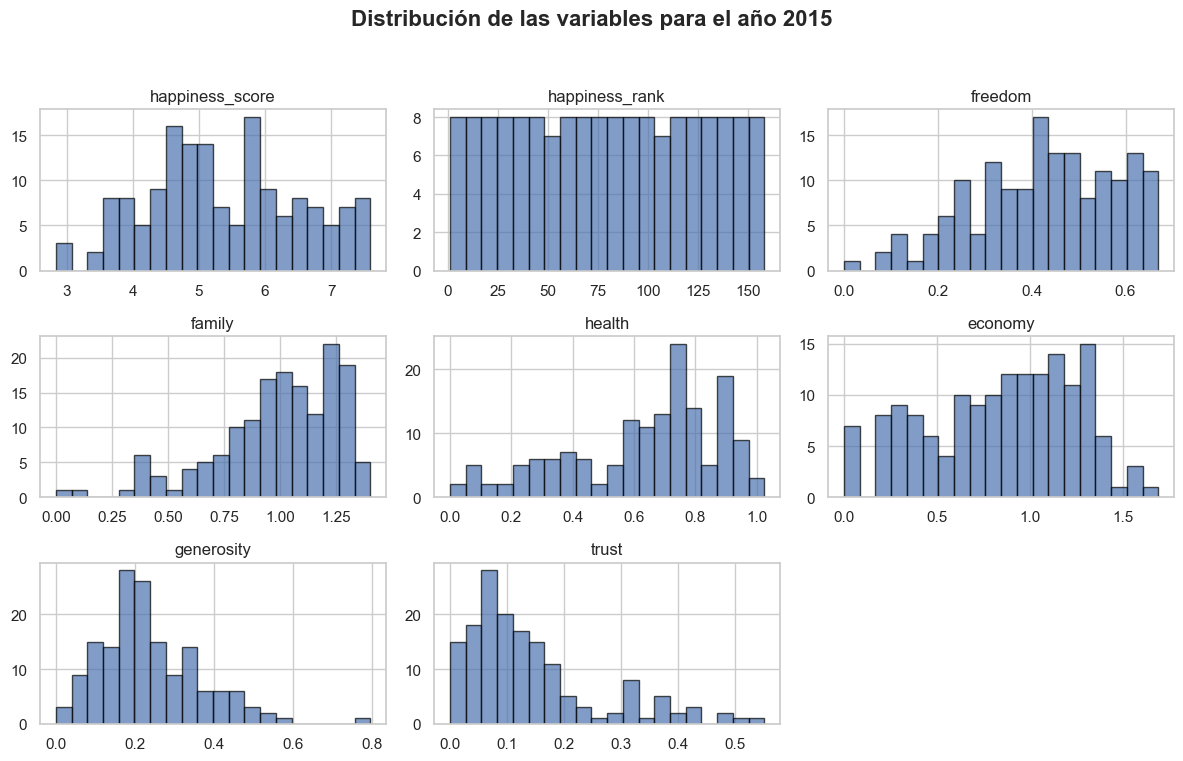

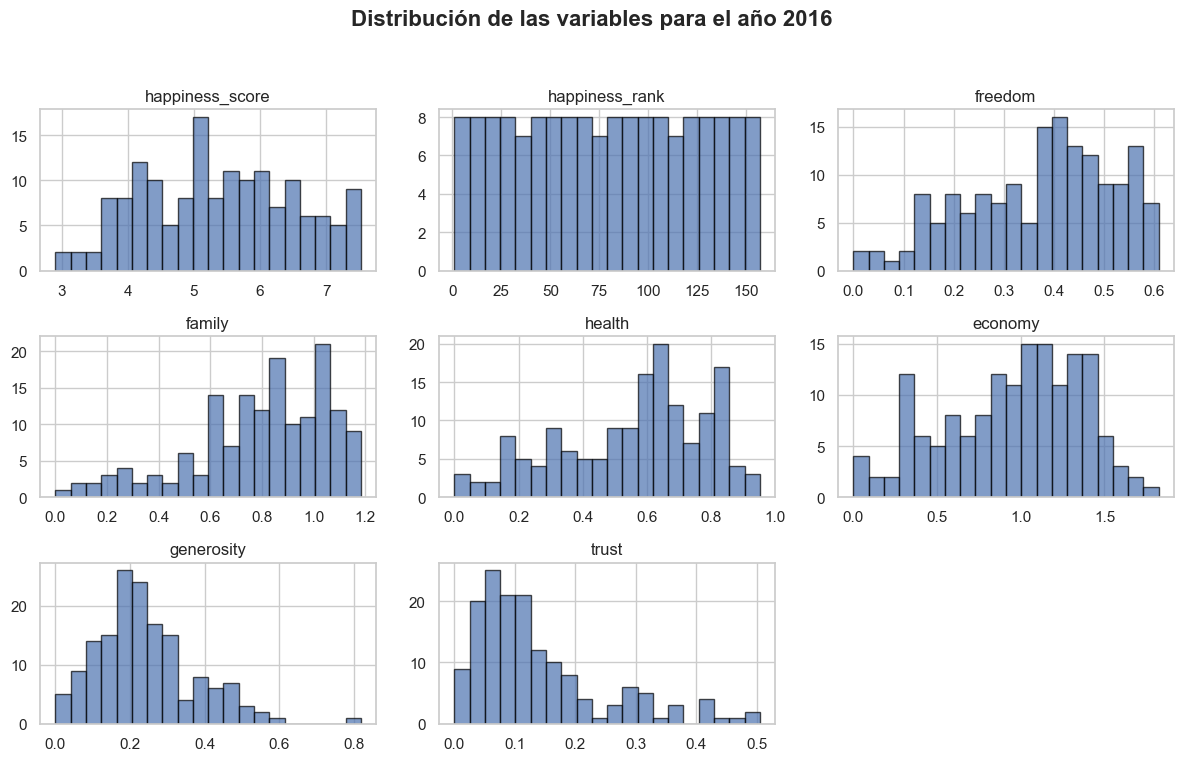

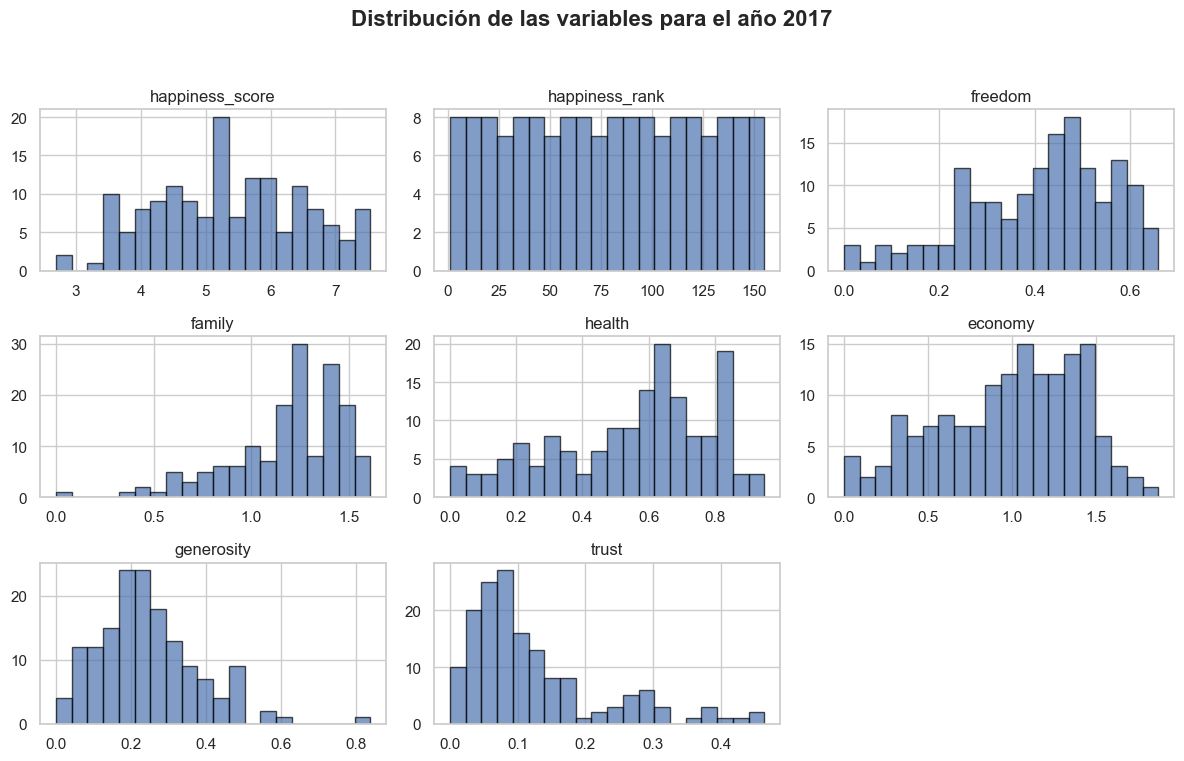

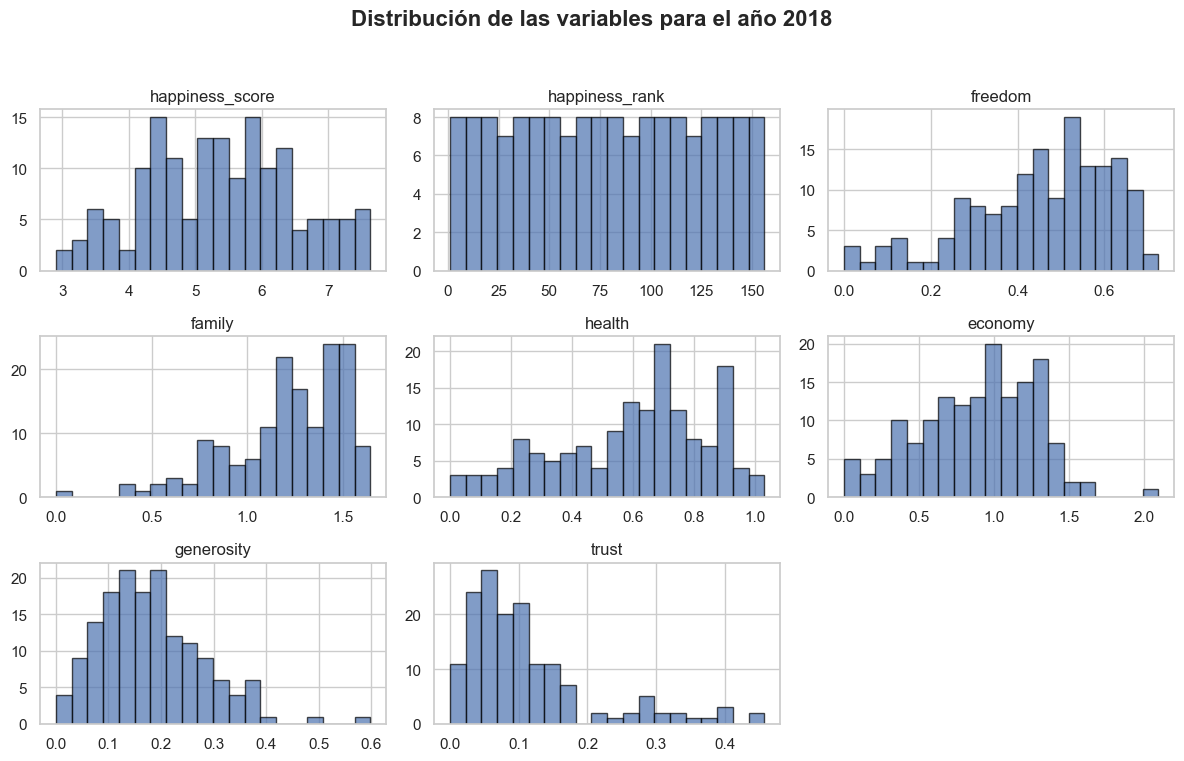

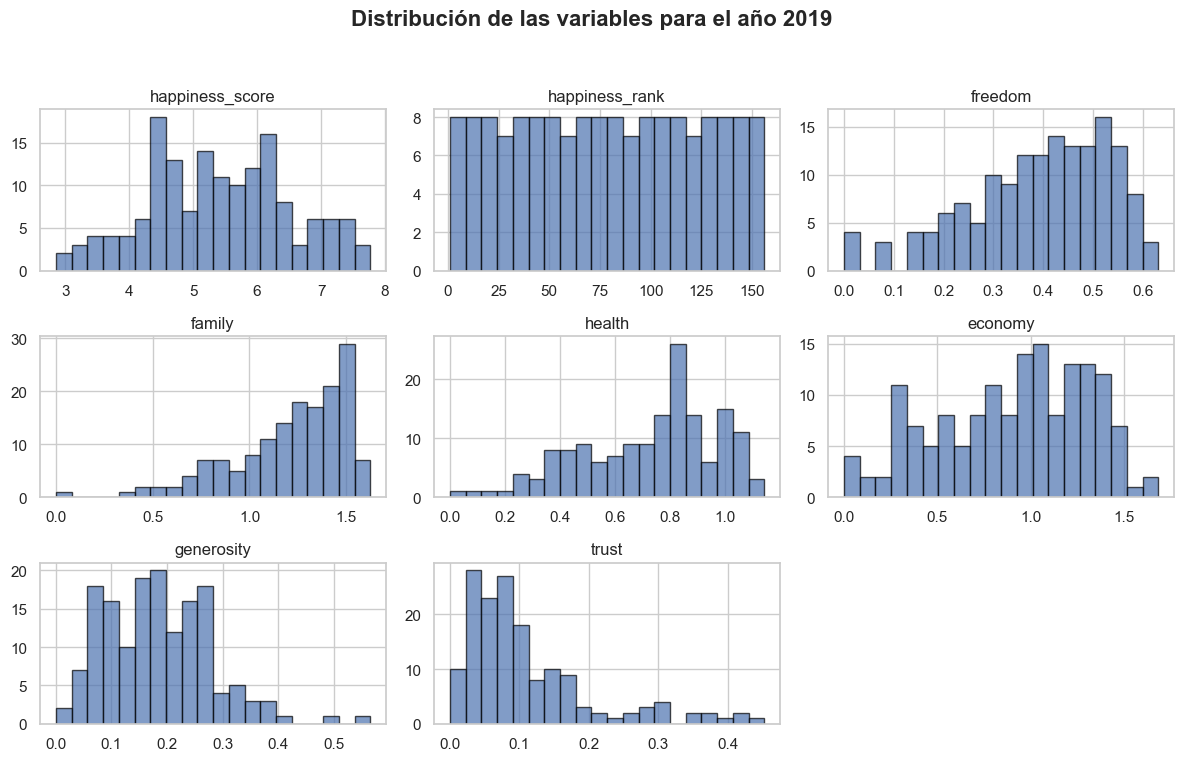

In [11]:
# Configuración estética de los gráficos
sns.set(style="whitegrid")  # Estilo de fondo blanco con líneas de cuadrícula
plt.rcParams["figure.figsize"] = (12, 8)  # Tamaño por defecto de las figuras

# Iterar sobre los DataFrames
for year, df in dfs.items():
    # Generar el histograma de todas las columnas numéricas
    df_numeric = df.select_dtypes(include=['number'])

    # Crear un histograma para cada columna numérica
    df_numeric.hist(bins=20, edgecolor='black', alpha=0.7)

    # Título y etiquetas
    plt.suptitle(f"Distribución de las variables para el año {year}", fontsize=16, fontweight='bold')
    plt.xlabel('Valor', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)

    # Ajustar el layout para que todo encaje bien
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Mostrar el gráfico
    plt.show()


Como la distribución de `trust` para 2028 está sesgada a la derecha (right-skewed), la mediana es una opción más robusta que la media para imputar valores nulos. En este caso hay un solo valor nulo, y se manejará imputando la mediana.


In [12]:
#Calcular la mediana de 'trust' para 2018
median_trust_2018 = dfs['2018']['trust'].median()

# Imputar valores nulos con la mediana
dfs['2018']['trust'].fillna(median_trust_2018, inplace=True)

# Verificar que ya no hay valores nulos
print(dfs['2018']['trust'].isnull().sum())

0


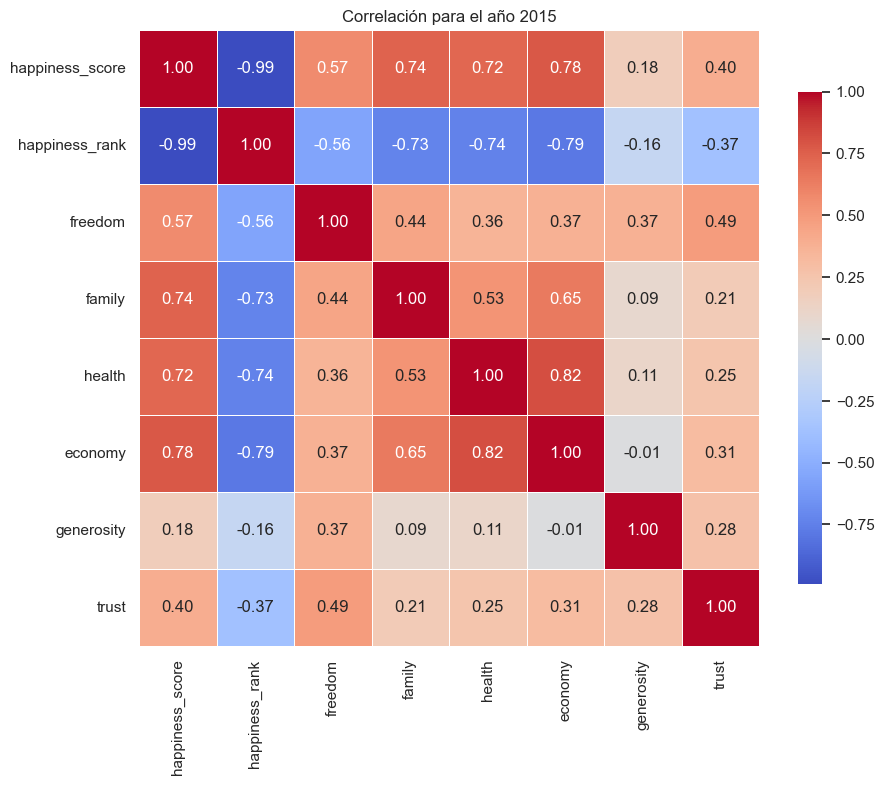

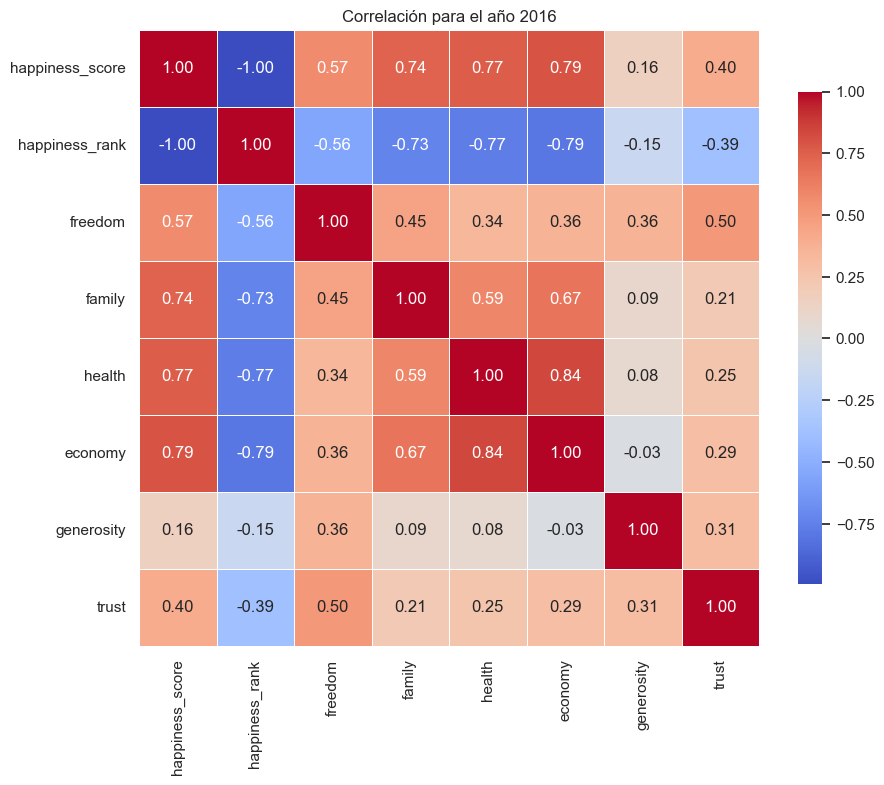

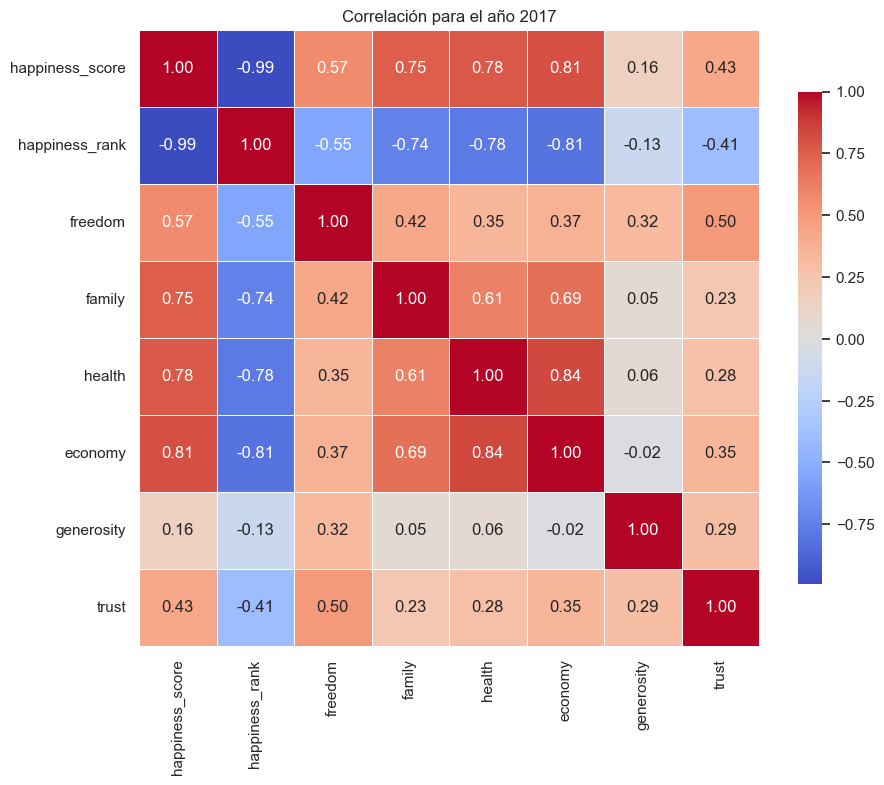

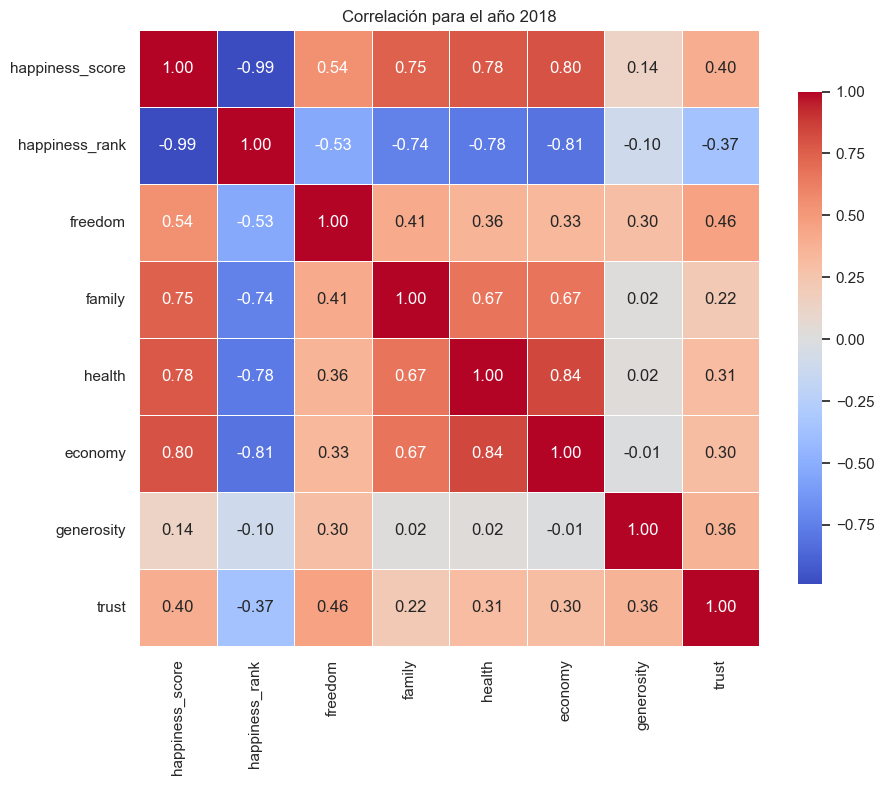

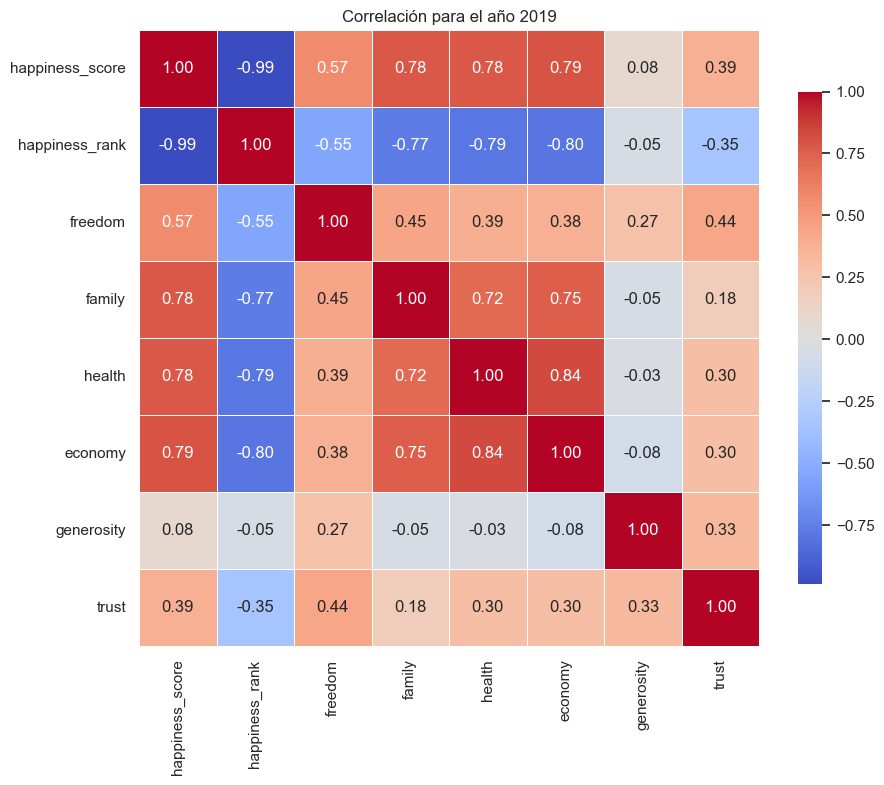

In [13]:
# Iterar sobre los DataFrames
for year, df in dfs.items():
    # Seleccionar solo las columnas numéricas (sin necesidad de eliminar la columna 'Country')
    df_numeric = df.select_dtypes(include=['number'])

    # Calcular la matriz de correlación para las columnas numéricas
    corr = df_numeric.corr()

    # Crear un mapa de calor para la matriz de correlación
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.8})

    # Título del gráfico
    plt.title(f"Correlación para el año {year}")
    plt.show()

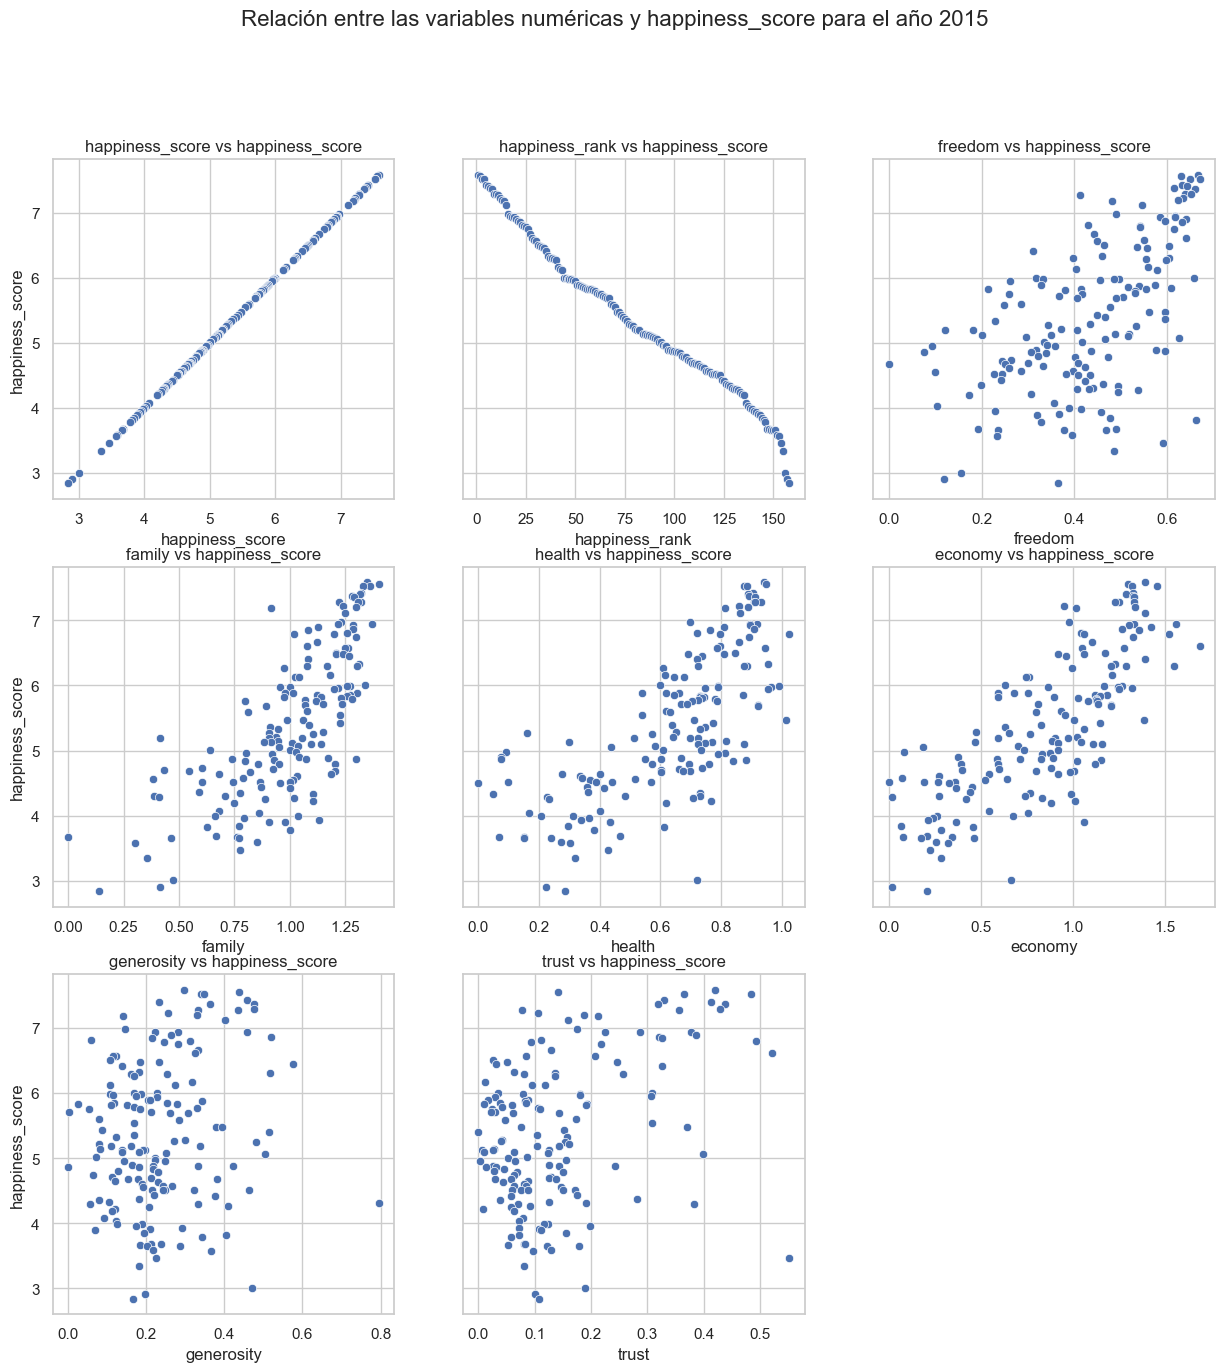

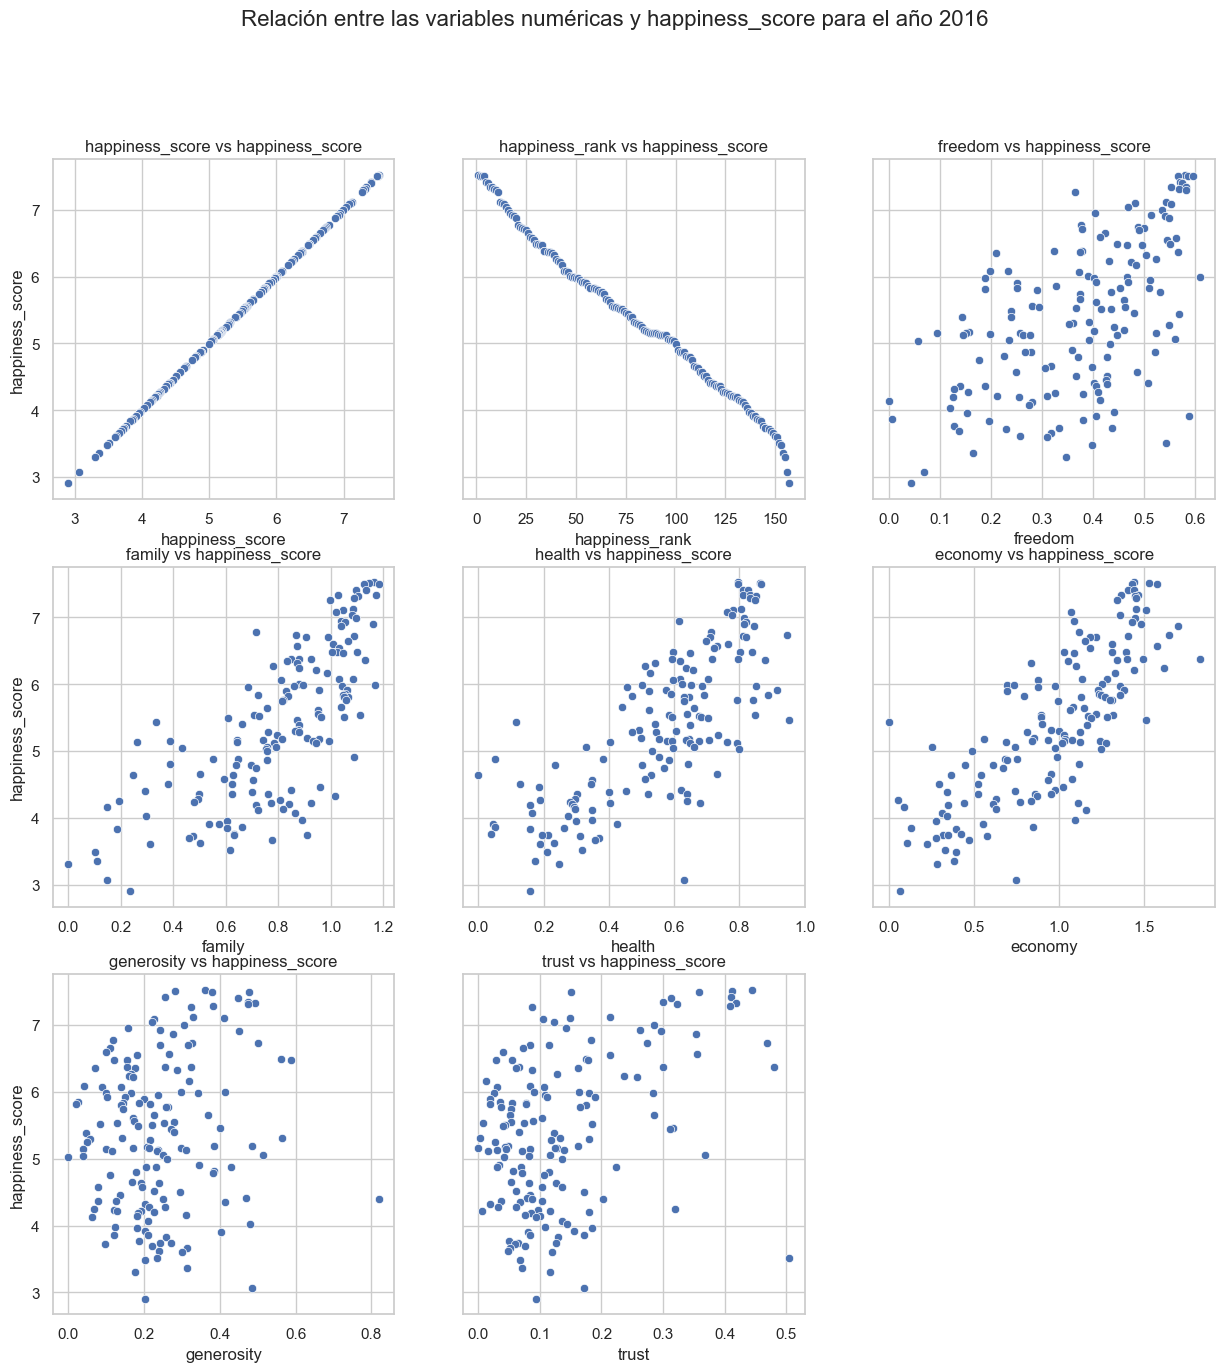

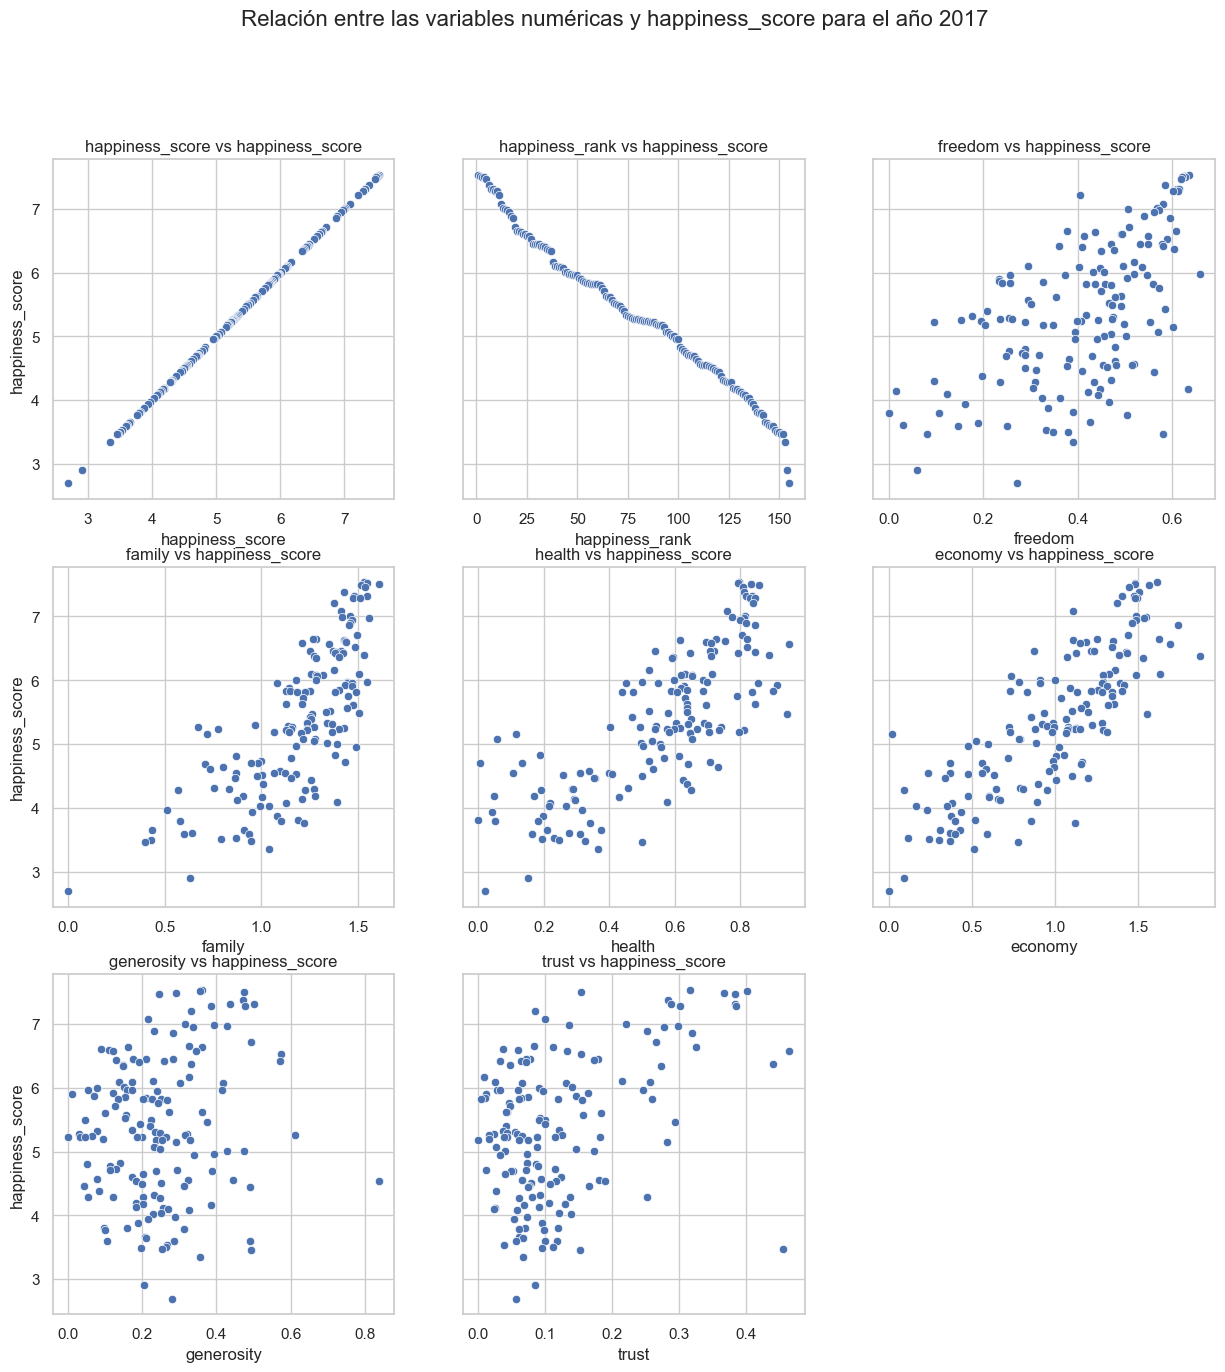

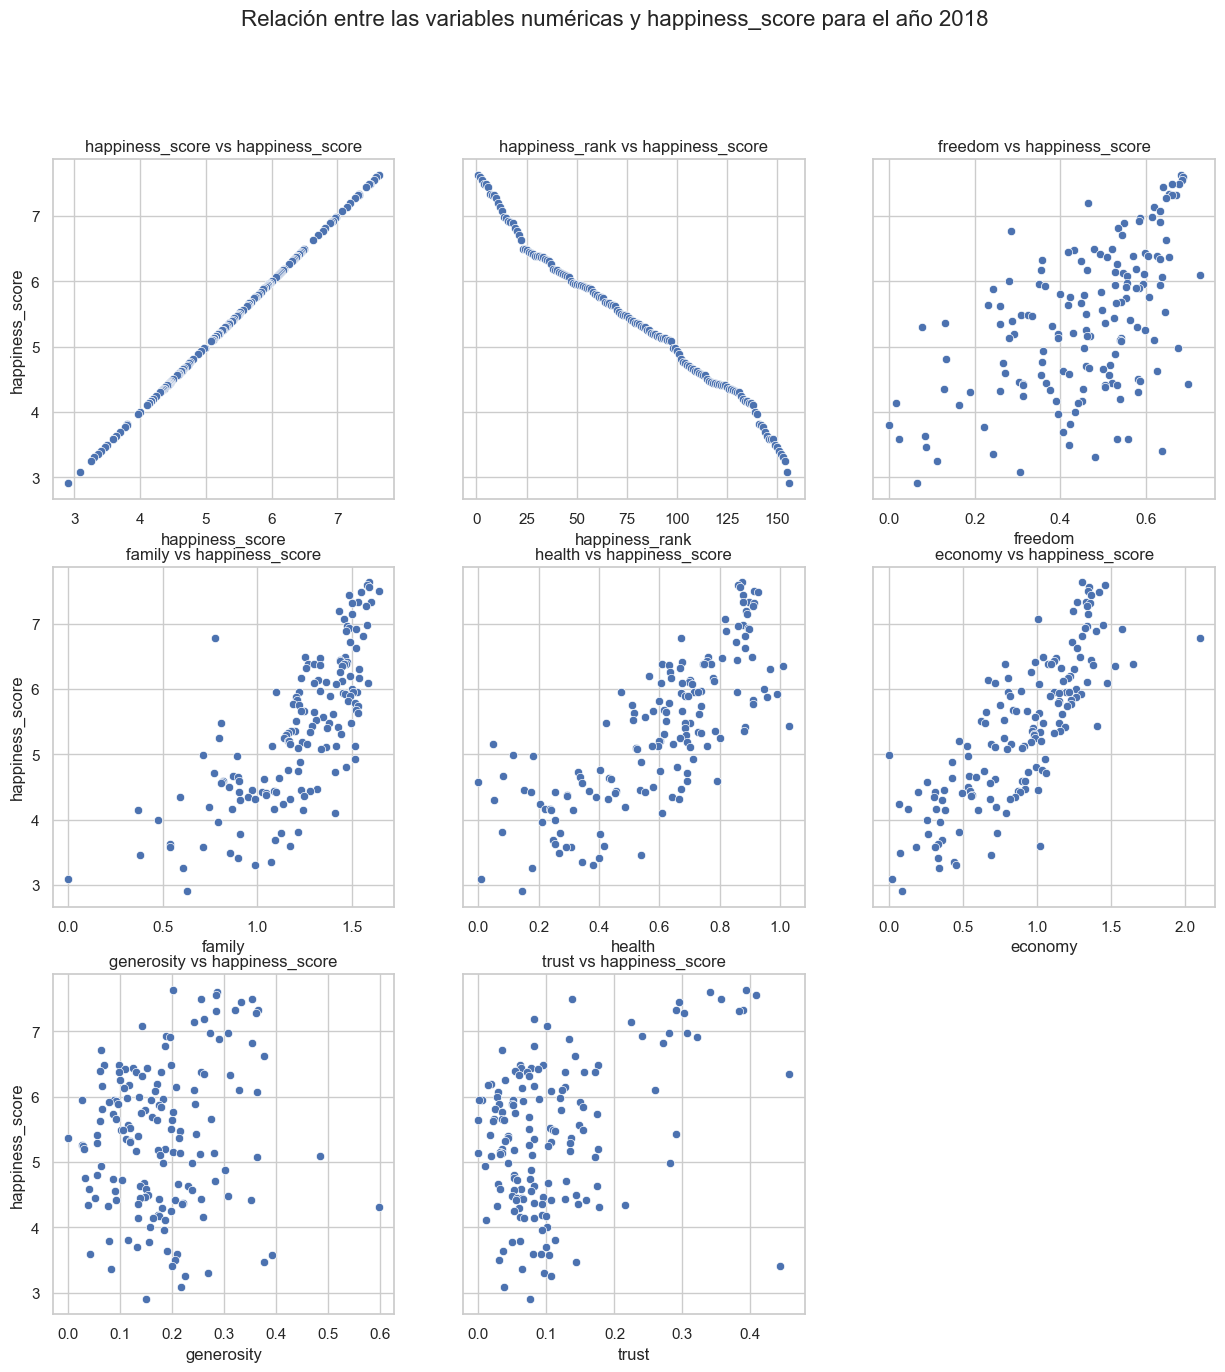

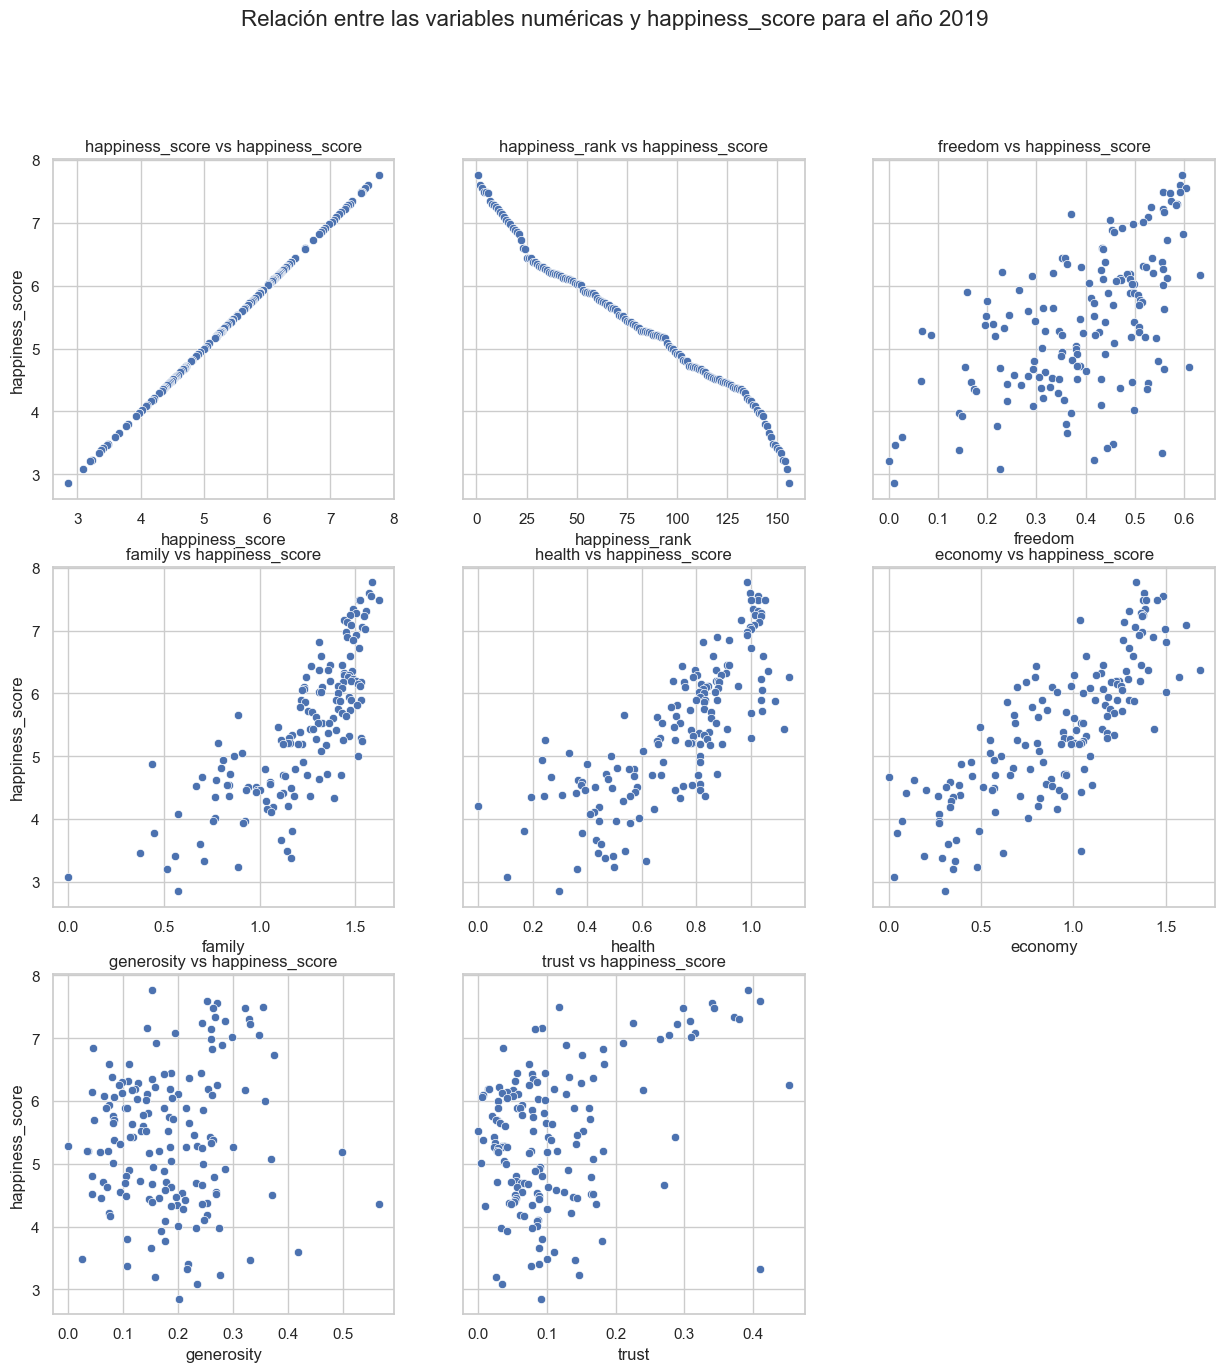

In [14]:
target_column = 'happiness_score'  # Reemplaza con tu columna objetivo

# Iterar sobre los DataFrames
for year, df in dfs.items():
    df_numeric = df.select_dtypes(include=['number'])
    num_columns = len(df_numeric.columns)

    # Definir el número de filas y columnas dinámicamente
    num_rows = int(np.ceil(num_columns / 3))  # Ajusta el divisor según el número máximo de columnas por fila
    num_cols = min(3, num_columns)  # Máximo 3 columnas por fila para mejor organización

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows), sharey=True)
    axes = axes.flatten()  # Asegurar que sea una lista plana para iterar fácilmente

    # Iterar sobre las columnas numéricas y graficarlas en subgráficas
    for ax, column in zip(axes, df_numeric.columns):
        sns.scatterplot(x=df[column], y=df[target_column], ax=ax)
        ax.set_title(f"{column} vs {target_column}")
        ax.set_xlabel(column)

    # Ocultar ejes no utilizados
    for i in range(num_columns, len(axes)):
        fig.delaxes(axes[i])

    fig.suptitle(f"Relación entre las variables numéricas y {target_column} para el año {year}", fontsize=16)
    
    plt.show()

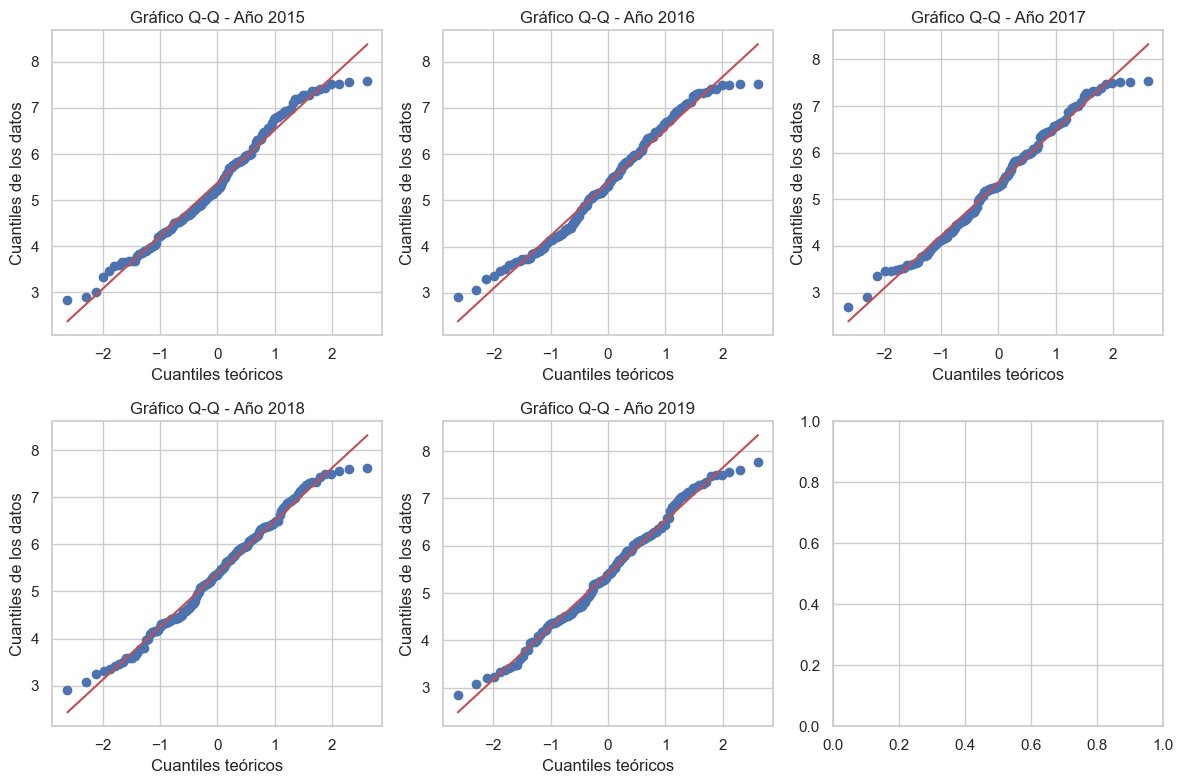

In [25]:
# Definir número de filas y columnas
num_rows = 2
num_cols = 3

# Crear la figura con subgráficos
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 8))

# Iterar sobre cada DataFrame y graficar en la posición correcta
for idx, (year, df) in enumerate(dfs.items()):
    row = idx // num_cols  # Calcular la fila correcta
    col = idx % num_cols   # Calcular la columna correcta

    column_name = "happiness_score"  # Cambia esto por el nombre correcto
    data = df[column_name].dropna()  # Eliminar valores NaN
    
    # Crear gráfico Q-Q en la posición correspondiente
    stats.probplot(data, dist="norm", plot=axes[row, col])
    axes[row, col].set_title(f"Gráfico Q-Q - Año {year}")
    axes[row, col].set_xlabel("Cuantiles teóricos")
    axes[row, col].set_ylabel("Cuantiles de los datos")

# Ajustar el diseño para evitar superposición de gráficos
plt.tight_layout()
plt.show()

In [35]:
# Initialize an empty list to store results
results = []

# Evaluate normality using the D'Agostino-Pearson test
for year, df in dfs.items():
    data = df[column_name].dropna()
    
    stat, p_value = normaltest(data)
    
    # Determine normality status
    normality = "✅ Normal" if p_value > 0.05 else "❌ Not Normal"
    
    # Append results to the list
    results.append({"Year": year, "Test Statistic": stat, "p-value": p_value, "Normality": normality})

# Convert list to DataFrame for better visualization
import pandas as pd
df_results = pd.DataFrame(results)
print(df_results)

   Year  Test Statistic   p-value     Normality
0  2015       10.166541  0.006200  ❌ Not Normal
1  2016       16.159532  0.000310  ❌ Not Normal
2  2017        8.641125  0.013292  ❌ Not Normal
3  2018        7.281097  0.026238  ❌ Not Normal
4  2019        4.465227  0.107248      ✅ Normal


### **Normality Test Interpretation**
The D'Agostino-Pearson test evaluates whether the data follows a normal distribution. Based on the p-values:
- **Years 2015-2018** show **p-values < 0.05**, indicating **non-normal distributions** ❌.
- **Year 2019** has **p-value > 0.05**, suggesting that the data **could be normal** ✅.

This means that transformations (e.g., Box-Cox or log transformations) may be necessary for years with non-normal distributions (all except `2019` )before applying certain predictive models.

In [37]:
# Crear una lista para almacenar los resultados
results = []

# Calcular skewness y kurtosis para cada año
for year, df in dfs.items():
    data = df["happiness_score"].dropna()
    skewness = skew(data)
    kurt = kurtosis(data)
    
    # Interpretaciones
    skew_interpretation = "Slight right skew" if skewness > 0 else "Slight left skew" if skewness < 0 else "Approximately symmetric"
    kurt_interpretation = "High kurtosis (extreme values)" if kurt > 3 else "Low kurtosis (uniform distribution)"
    
    # Agregar resultados a la lista
    results.append([year, round(skewness, 4), round(kurt, 4), skew_interpretation, kurt_interpretation])

# Convertir la lista en un DataFrame
table = pd.DataFrame(results, columns=["Year", "Skewness", "Kurtosis", "Skewness Interpretation", "Kurtosis Interpretation"])

# Mostrar la tabla
table

,Year,Skewness,Kurtosis,Skewness Interpretation,Kurtosis Interpretation
0,2015,0.0968,-0.7895,Slight right skew,Low kurtosis (uniform distribution)
1,2016,0.0433,-0.8999,Slight right skew,Low kurtosis (uniform distribution)
2,2017,0.0095,-0.7649,Slight right skew,Low kurtosis (uniform distribution)
3,2018,0.0150,-0.7264,Slight right skew,Low kurtosis (uniform distribution)
4,2019,0.0113,-0.6273,Slight right skew,Low kurtosis (uniform distribution)


### **Skewness & Kurtosis Interpretation**

1️⃣ **Skewness** is **very low** across all years, meaning the distribution is **almost symmetric**, with only a slight rightward bias.  
2️⃣ **Kurtosis** is **negative** in all cases, indicating that the distribution is **platykurtic** (flatter and with fewer extreme values). This suggests that the data is more concentrated around the mean, without long tails.  

**How does this affect model selection?**  
- Since **there is no strong skew**, it is unnecessary to use models that correct extreme asymmetry (such as Gamma or logit).  
- Low kurtosis indicates **moderate data variability**, which may favor a **standard linear model**.  
- If values are restricted between **0 and 10**, a **Beta Regression** (with Min-Max Scaling transformation) could be a good option.  
- We can also try a **Classic Linear Regression** or a **GLM with identity function**, as the distribution appears quite stable. 

### **Model selection**

Since the **2019 dataset passes the normality test (p-value > 0.05),** a standard linear regression model should work well without requiring transformations. However, because we are incorporating data from other years to predict `happiness_score`—and these years deviate from normality—**Generalized Linear Models (GLMs) provide a more robust approach** for handling non-normal distributions effectively. By choosing a GLM, we can account for the variability in the data while ensuring a more flexible and accurate predictive model.

However, it is also important to remember that the **happiness ranking (score)** is derived from the **Cantril Ladder**, which measures life evaluation on a **0-10 scale**, so there a couple of to considerations when working to predict these values with a model:


1️⃣ **Bounded Nature (0-10 Scale)**
   - Since the scores are constrained within **a fixed range**, standard linear regression **may not be the best choice**, as it can predict values outside this interval.
   - Instead, models that respect boundaries (like **Beta Regression**) could be a better fit.

2️⃣ **Distribution of Values**
   - If scores **are mostly clustered around certain values** (e.g., many countries rate between 6-8), a **transformation** like **Min-Max Scaling** or **Z-score normalization** might help standardize input data.
   - If skewed, **Box-Cox transformation** could improve symmetry before regression.

3️⃣ **Ordinal vs. Continuous Treatment**
   - While the Cantril Ladder is numeric, some researchers treat it as an **ordinal** variable rather than purely continuous.
   - If ranking matters more than the numeric score, **Ordinal Regression** (e.g., Proportional Odds Model) might be relevant.

### **Recommended Approaches**:
✅ **Beta Regression** → Best for **bounded scores** between 0 and 10.  
✅ **Generalized Linear Models (GLMs)** → Gamma or Gaussian (with proper transformations).  
✅ **Ordinal Regression** → If treating happiness as a ranked perception rather than purely numeric.  

